## Index

[1 Import Packages](#1)<br>
[2 Load Dataset](#2)<br>
[3 Data Preprocessing](#3)<br>
[4 Train Network](#4)<br>
    <ul>
        <li>[4.1 Basic approach](#41)</li>
        <li>[4.2 Convolutional approach ](#42)</li>
    </ul>
[5. Evaluation of the model](#5)<br>
    <ul>
        <li>[5.1 Confusion matrix and metrics](#51)</li>
    </ul>
[6. Save and load the model](#6)<br>
[7. References](#7)<br>

<a id='1'></a>
<div class="alert alert-block alert-danger">
<h2>1 Import Packages</h2>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.models import load_model

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
import tensorflow_datasets as tfds

## hide progress bar while executing
# tfds.disable.progress_bar()

<a id='2'></a>
<div class="alert alert-block alert-danger">
   <h2>
    2 Load Dataset
    </h2>
</div>

In [3]:
# tensorflow built-in datasets
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_mujoco_ant',
 'd4

<div class="alert alert-block alert-success">
        <strong>Get information on the Data</strong>
</div>

In [4]:
builder = tfds.builder('rock_paper_scissors')

info = builder.info
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='/Users/onurkaraguler/tensorflow_datasets/rock_paper_scissors/3.0.0',
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

- Image(shape=(300, 300, 3) -> RGB image
- dtype=tf.uint8 -> Data type
- 'train': ...num_examples=2520... -> 2520 images for train
- 'test': ...num_examples=372... -> 372 images for train

In [5]:
ds_train = tfds.load(name='rock_paper_scissors', split='train')
ds_test = tfds.load(name='rock_paper_scissors', split='test')

Metal device set to: Apple M1


2021-08-05 16:26:38.557913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-05 16:26:38.558004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
ds_train

<PrefetchDataset shapes: {image: (300, 300, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

2021-08-05 16:26:38.655903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-05 16:26:38.656330: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-08-05 16:26:38.678881: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


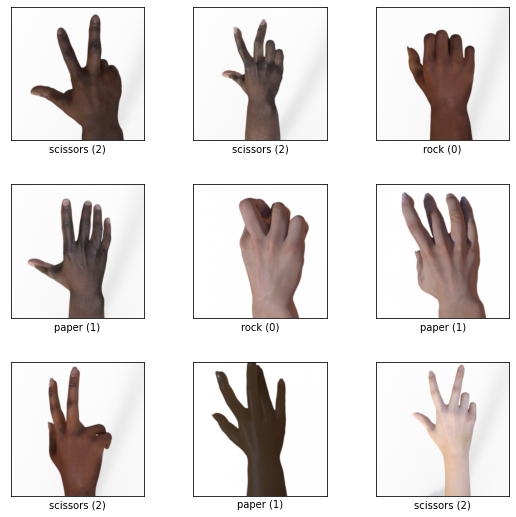

In [7]:
fig = tfds.show_examples(ds_train, info)

<a id='3'></a>
<div class="alert alert-block alert-danger">
   <h2>
    3 Data Preprocessing
    </h2>
</div>

In [8]:
train_images = [example['image'] for example in ds_train]
type(train_images[0])

tensorflow.python.framework.ops.EagerTensor

- Data type is Tensorflow tensor

In [9]:
train_images = np.array([example['image'].numpy() for example in ds_train])
type(train_images[0])

numpy.ndarray

- Tensorflow tensor to numpy array

In [10]:
for i in train_images:
    print(i.shape)
    break

(300, 300, 3)


In [11]:
train_images.shape

(2520, 300, 300, 3)

In [12]:
for i in ds_train:
    print(i['label'].numpy())
    print(i['image'].numpy().shape)
    print(i['image'].numpy()[:, :, 0].shape)
    break

2
(300, 300, 3)
(300, 300)


- Color is not important for this study. Trying to find edges are enough. [:, :, 0] the first and second color channels will be taken. The last color channel will be removed. 

In [13]:
train_images = np.array([example['image'].numpy()[:, :, 0] for example in ds_train])
train_labels = np.array([example['label'].numpy() for example in ds_train])

test_images = np.array([example['image'].numpy()[:, :, 0] for example in ds_test])
test_labels = np.array([example['label'].numpy() for example in ds_test])

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(2520, 300, 300)
(2520,)
(372, 300, 300)
(372,)


<div class="alert alert-block alert-success">
        <strong>Resize images</strong>
</div>

In [14]:
def resize_images(img):
    img_height = img_width = 28
    img = cv2.resize(img, (img_height, img_width))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # to read images grayscale

    # color channel must be for Convolutional Neural Network in Keras. 1 represents gray color.
    img = np.reshape(img, (img_height, img_width, 1))
    return img

In [15]:
# convert list to numpy array
train_images = np.array([resize_images(img) for img in train_images])
test_images = np.array([resize_images(img) for img in test_images])

print(train_images.shape)
print(test_images.shape)

(2520, 28, 28, 1)
(372, 28, 28, 1)


<div class="alert alert-block alert-success">
        <strong>Plot some of the reshaped images</strong>
</div>

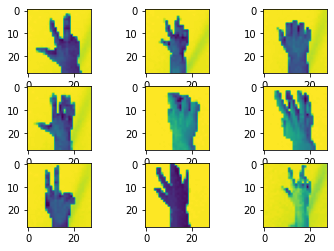

In [16]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(array_to_img(train_images[i]))
plt.show()

<div class="alert alert-block alert-success">
        <strong>Normalisation</strong>
</div>

In [17]:
# Scaling every value between 0-1 to increase the performance
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [18]:
train_images[0].shape

(28, 28, 1)

In [19]:
test_images.dtype 

dtype('float32')

<a id='4'></a>
<div class="alert alert-block alert-danger">
   <h2>
    4 Train Network
    </h2>
</div>

In [20]:
def plot_losses(acc, val_acc, loss, val_loss):
    
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # accuracy
    axes[0].plot(epochs, acc, 'b', color='green', linewidth=2, label='Training accuracy')
    axes[0].plot(epochs, val_acc, color='blue', linewidth=2, label='Validation accuracy')
    axes[0].fill_between(epochs, acc, val_acc, color='red', alpha=0.3)
    axes[0].set_title('Training and validation accuracy', color='red', size=14)
    axes[0].set_xlabel('Epochs', size=12)
    axes[0].set_ylabel('Accuracy', size=12)
    axes[0].legend(title='Accuracy')
    
    # loss
    axes[1].plot(epochs, loss, 'b', color='green', linewidth=2, label='Training loss')
    axes[1].plot(epochs, val_loss, 'b', color='blue', linewidth=2, label='Validation loss')
    axes[1].fill_between(epochs, loss, val_loss, color='red', alpha=0.3)
    axes[1].set_title('Training and validation loss', color='red', size=14)
    axes[1].set_xlabel('Epochs', size=12)
    axes[1].set_ylabel('Loss', size=12)
    axes[1].legend(title='Loss')
    
    fig.tight_layout()
    plt.show()

<a id='41'></a>
<div class="alert alert-block alert-info">
   <h3>
        4.1 Basic approach
   </h3>
</div>

In [21]:
model = Sequential([
    Flatten(),
    Dense(521, activation='relu'),
    Dense(256, activation='relu'),
    # 3 -> (rock, paper, scissors)
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [22]:
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, 
                    batch_size=32)

Epoch 1/10
19/79 [======>.......................] - ETA: 0s - loss: 1.3727 - accuracy: 0.3799

2021-08-05 16:26:42.313469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 8ms/step - loss: 1.0707 - accuracy: 0.4980 - val_loss: 1.0614 - val_accuracy: 0.4677
Epoch 2/10
19/79 [======>.......................] - ETA: 0s - loss: 0.8215 - accuracy: 0.6480

2021-08-05 16:26:42.901858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 7ms/step - loss: 0.7565 - accuracy: 0.6623 - val_loss: 1.1405 - val_accuracy: 0.4274
Epoch 3/10
79/79 [==============================] - 1s 7ms/step - loss: 0.5489 - accuracy: 0.7937 - val_loss: 1.5727 - val_accuracy: 0.4113
Epoch 4/10
79/79 [==============================] - 1s 7ms/step - loss: 0.4548 - accuracy: 0.8258 - val_loss: 1.0887 - val_accuracy: 0.5269
Epoch 5/10
79/79 [==============================] - 1s 6ms/step - loss: 0.3826 - accuracy: 0.8595 - val_loss: 1.3435 - val_accuracy: 0.4597
Epoch 6/10
79/79 [==============================] - 0s 6ms/step - loss: 0.2627 - accuracy: 0.9147 - val_loss: 1.3220 - val_accuracy: 0.5296
Epoch 7/10
79/79 [==============================] - 0s 6ms/step - loss: 0.2575 - accuracy: 0.9028 - val_loss: 1.4222 - val_accuracy: 0.5968
Epoch 8/10
79/79 [==============================] - 0s 6ms/step - loss: 0.1797 - accuracy: 0.9413 - val_loss: 1.6901 - val_accuracy: 0.5914
Epoch 9/10
79/79 [=============

- accuracy for the training set is 97%, but 47% for the test
- overfitting problem

<div class="alert alert-block alert-success">
        <strong>Plot some of the reshaped images</strong>
</div>

In [23]:
for i in history.history:
    print(i)

loss
accuracy
val_loss
val_accuracy


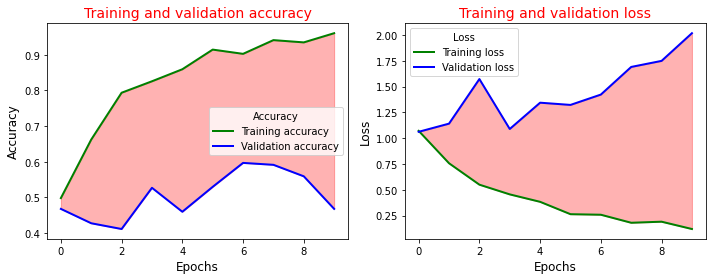

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot_losses(acc, val_acc, loss, val_loss)

<a id='42'></a>
<div class="alert alert-block alert-info">
   <h3>
        4.2 Convolutional approach
   </h3>
</div>

<div>
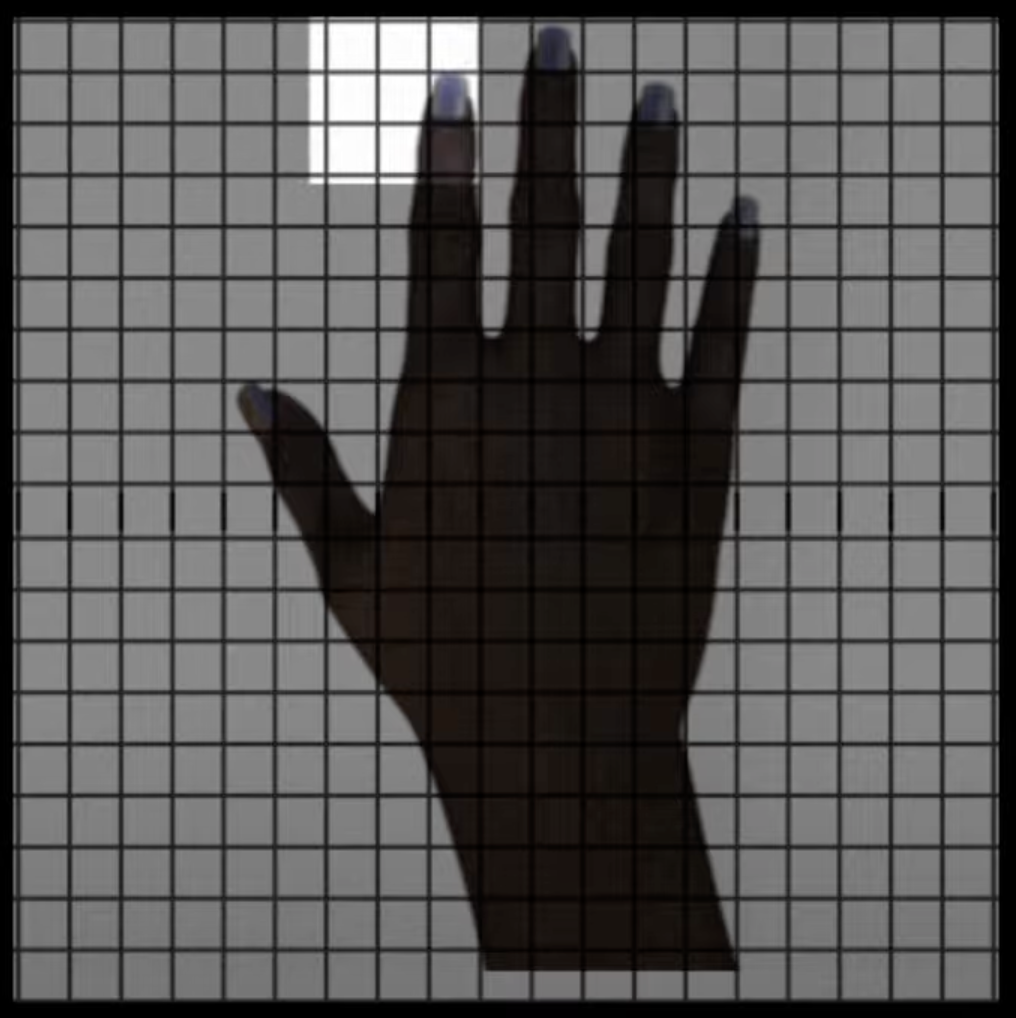
</div>

In [25]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3)(inputs)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [26]:
model.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [27]:
%%time
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30, 
                    batch_size=16)

Epoch 1/30
  7/158 [>.............................] - ETA: 1s - loss: 0.8924 - accuracy: 0.5982 

2021-08-05 16:26:47.846877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 2s 10ms/step - loss: 0.0866 - accuracy: 0.9694 - val_loss: 2.0347 - val_accuracy: 0.3333
Epoch 2/30
  7/158 [>.............................] - ETA: 1s - loss: 7.2238e-04 - accuracy: 1.0000

2021-08-05 16:26:49.417610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.8230 - val_accuracy: 0.3333
Epoch 3/30
158/158 [==============================] - 1s 9ms/step - loss: 2.3420e-04 - accuracy: 1.0000 - val_loss: 2.0148 - val_accuracy: 0.5806
Epoch 4/30
158/158 [==============================] - 1s 9ms/step - loss: 1.3780e-04 - accuracy: 1.0000 - val_loss: 1.2752 - val_accuracy: 0.7070
Epoch 5/30
158/158 [==============================] - 1s 9ms/step - loss: 9.9429e-05 - accuracy: 1.0000 - val_loss: 1.0139 - val_accuracy: 0.7473
Epoch 6/30
158/158 [==============================] - 1s 9ms/step - loss: 6.5639e-05 - accuracy: 1.0000 - val_loss: 0.9653 - val_accuracy: 0.7392
Epoch 7/30
158/158 [==============================] - 1s 9ms/step - loss: 5.5200e-05 - accuracy: 1.0000 - val_loss: 1.0033 - val_accuracy: 0.7500
Epoch 8/30
158/158 [==============================] - 1s 9ms/step - loss: 3.9422e-05 - accuracy: 1.0000 - val_loss: 0.9235 - val_accuracy: 

<div class="alert alert-block alert-success">
        <strong>Plot some of the reshaped images</strong>
</div>

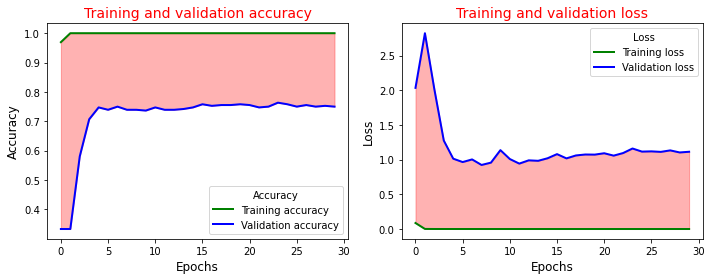

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot_losses(acc, val_acc, loss, val_loss)

In [29]:
%%time
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='sigmoid')
])

##################

model.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

##################

history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30, 
                    batch_size=16)

Epoch 1/30
  7/158 [>.............................] - ETA: 1s - loss: 1.8101 - accuracy: 0.4018 

2021-08-05 16:27:32.834433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 2s 10ms/step - loss: 0.8474 - accuracy: 0.6421 - val_loss: 2.4395 - val_accuracy: 0.3333
Epoch 2/30
  7/158 [>.............................] - ETA: 1s - loss: 0.6383 - accuracy: 0.7500

2021-08-05 16:27:34.418687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 2s 10ms/step - loss: 0.4472 - accuracy: 0.8302 - val_loss: 4.2587 - val_accuracy: 0.3333
Epoch 3/30
158/158 [==============================] - 2s 10ms/step - loss: 0.2988 - accuracy: 0.8841 - val_loss: 1.8774 - val_accuracy: 0.3414
Epoch 4/30
158/158 [==============================] - 2s 10ms/step - loss: 0.2233 - accuracy: 0.9198 - val_loss: 0.8116 - val_accuracy: 0.7634
Epoch 5/30
158/158 [==============================] - 2s 10ms/step - loss: 0.1599 - accuracy: 0.9433 - val_loss: 0.6299 - val_accuracy: 0.7715
Epoch 6/30
158/158 [==============================] - 2s 10ms/step - loss: 0.1230 - accuracy: 0.9567 - val_loss: 3.2926 - val_accuracy: 0.3548
Epoch 7/30
158/158 [==============================] - 2s 10ms/step - loss: 0.1048 - accuracy: 0.9579 - val_loss: 0.6335 - val_accuracy: 0.7097
Epoch 8/30
158/158 [==============================] - 2s 10ms/step - loss: 0.0600 - accuracy: 0.9782 - val_loss: 1.3171 - val_accuracy: 0.5887
Epoch 9/30

<div class="alert alert-block alert-success">
        <strong>Plot some of the reshaped images</strong>
</div>

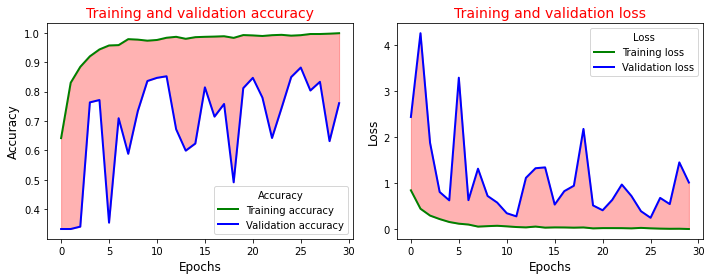

In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot_losses(acc, val_acc, loss, val_loss)

<a id='5'></a>
<div class="alert alert-block alert-danger">
   <h2>
    5 Evaluation of the model
    </h2>
</div>

<a id='51'></a>
<div class="alert alert-block alert-info">
   <h3>
        5.1 Confusion matrix and metrics
   </h3>
</div>

<div>
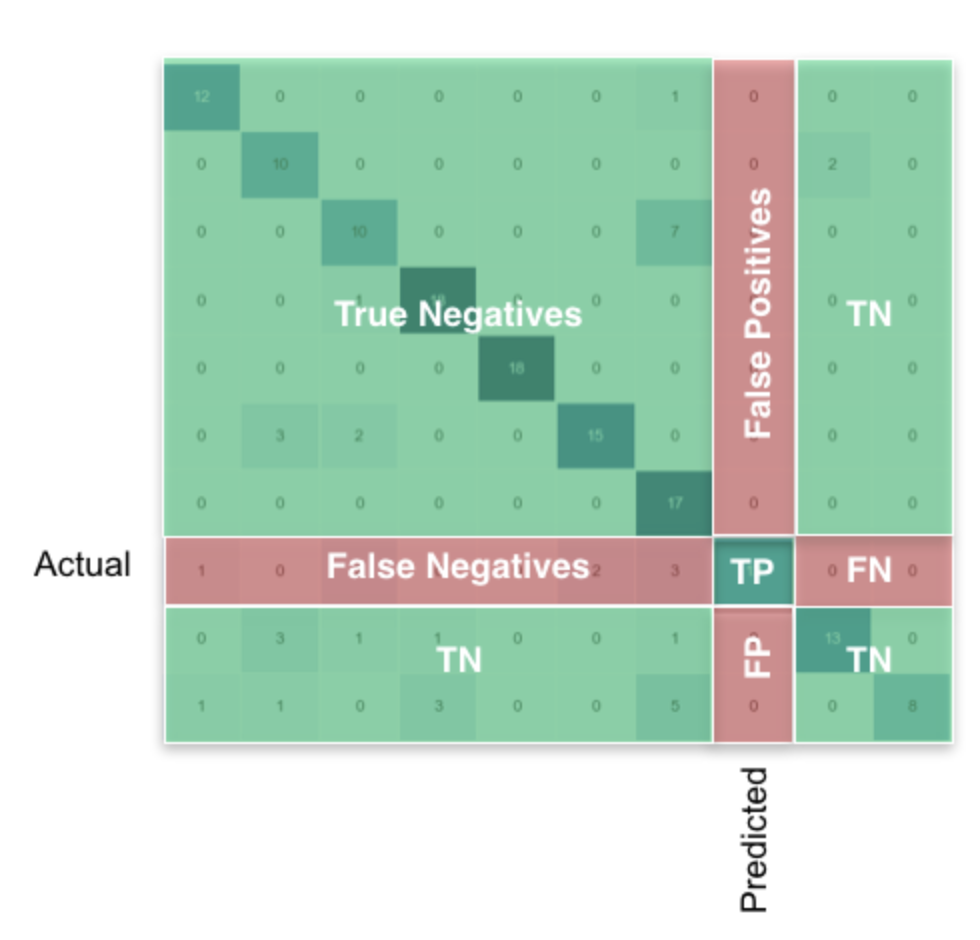
</div>

In [31]:
import math

def confusion_matrix_metrics(TP, FP, FN, TN):
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)

    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)
    # balanced accuracy (BA)
    BA = round((TPR + TNR) / 2, 2)

    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    NPV = round(TN / (TN + FN), 2)
    # false discovery rate (FDR)
    FDR = round(1 - PPV, 2)
    # false omission rate (FOR)
    FOR = round(1 - NPV, 2)

    # prevalence threshold (PT)
    PT = round((math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1), 2)
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = round(((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)), 2)

    # False positive rate or False alarm rate
    FPR = round(FP / (FP + TN), 2)
    # False negative rate or Miss Rate
    FNR = round(FN / (FN + TP), 2)
    
    return TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR

In [32]:
def TP_FP_TN_FN_func(cm, dataframe):
    df_cm = pd.DataFrame(cm)
    TP = []
    FN = []
    TN = []
    FP = []
    for i in range(len(df_cm)):
        for j in range(len(df_cm.columns)):
            if i == j:
                # TP
                TP.append(df_cm.iloc[i,j])
                # FN
                df_FN = df_cm.drop(i, axis=0)
                FN_list = [row for row in range(len(df_cm)) if row != i]
                df_FN = df_FN.drop(FN_list, axis=1)
                FN.append(df_FN.sum().sum())
                # TN
                df_TN = df_cm.drop(i, axis=1)
                df_TN = df_TN.drop(i, axis=0)
                TN.append(df_TN.sum().sum())
                # FP
                df_FP = df_cm.drop(i, axis=1)
                FP_list = [row for row in range(len(df_cm)) if row != i]
                df_FP = df_FP.drop(FP_list, axis=0)
                FP.append(df_FP.sum().sum())
                
    metrics_list = []
    for i in range(len(TP)):
        # get the metric values from the confusion_matrix_metrics function
        (TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, 
         F1, MCC, FPR, FNR) = confusion_matrix_metrics(TP[i], FP[i], FN[i], TN[i])
        metrics_list.append([TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR])
    metrics_cols = ['True Positive Rate', 'True Negative Rate', 'Accuracy', 'Balanced Accuracy', 'Precision', 
                  'Negative Predictive Value', 'False Discovery Rate', 'False Omission Rate', 
                  'Prevalence Threshold', 'F1 Score', 'Matthews Correlation Coefficient', 
                  'False positive rate', 'False Negative Rate']
    
    # create a dataframe with multi-column
    l=[(dataframe, '0'),  (dataframe, '1'), (dataframe,'2')]
    df_cm_metrics = pd.DataFrame(metrics_list, columns=metrics_cols, index=l).T
    df_cm_metrics.columns = pd.MultiIndex.from_tuples(df_cm_metrics.columns, names=['Dataset','Metrics'])
    
    return df_cm_metrics

In [33]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_func(model, train_images, test_images, train_labels, test_labels):
    
    y_train_predicted = model.predict(train_images)
    y_test_predicted = model.predict(test_images)
    
    y_train_predicted_labels = [np.argmax(i) for i in y_train_predicted]
    y_test_predicted_labels = [np.argmax(i) for i in y_test_predicted]
    
    cm = confusion_matrix(train_labels, y_train_predicted_labels).T
    cm_test = confusion_matrix(test_labels, y_test_predicted_labels).T

    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the heatmap
    im = axes[0].imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')
    # show all ticks
    axes[0].set_xticks(np.arange(len(cm.tolist())))
    axes[0].set_yticks(np.arange(len(cm.tolist())))
    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = axes[0].text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
    # Let the horizontal axes labeling appear on top.
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')
    axes[0].set_xlabel('Actual value', size=16)
    axes[0].set_ylabel('Predicted value', size=16)
    axes[0].set_title("Train", fontsize=20)
    
    # Plot the heatmap
    im = axes[1].imshow(cm_test, interpolation='nearest', cmap='Reds', aspect='auto')
    # show all ticks
    axes[1].set_xticks(np.arange(len(cm_test.tolist())))
    axes[1].set_yticks(np.arange(len(cm_test.tolist())))
    thresh = cm_test.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm_test.tolist())):
        for j in range(len(cm_test.tolist())):
            text = axes[1].text(j, i, cm_test.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
    # Let the horizontal axes labeling appear on top.
    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')
    axes[1].set_xlabel('Actual value', size=16)
    axes[1].set_title("Test", fontsize=20)

    fig.tight_layout()
    fig.show()
    
    # get the metric values as a dataframe
    df_cm_metrics = TP_FP_TN_FN_func(cm, 'Train')
    df_cm_test_metrics = TP_FP_TN_FN_func(cm_test, 'Test')
    
    return df_cm_metrics, df_cm_test_metrics

2021-08-05 16:28:18.957641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


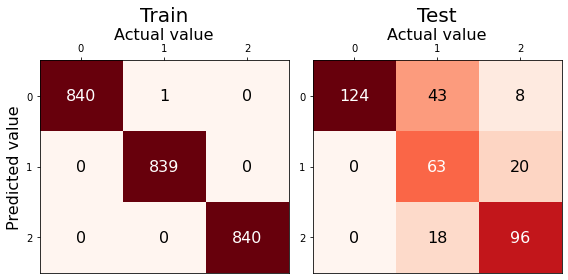

In [34]:
df_cm_metrics, df_cm_test_metrics = confusion_matrix_func(model, train_images, test_images, train_labels, test_labels)

In [35]:
pd.concat([df_cm_metrics, df_cm_test_metrics], axis=1)

Dataset                          Train            Test            
Metrics                              0    1    2     0     1     2
True Positive Rate                 1.0  1.0  1.0  1.00  0.51  0.77
True Negative Rate                 1.0  1.0  1.0  0.79  0.92  0.93
Accuracy                           1.0  1.0  1.0  0.86  0.78  0.88
Balanced Accuracy                  1.0  1.0  1.0  0.90  0.72  0.85
Precision                          1.0  1.0  1.0  0.71  0.76  0.84
Negative Predictive Value          1.0  1.0  1.0  1.00  0.79  0.89
False Discovery Rate               0.0  0.0  0.0  0.29  0.24  0.16
False Omission Rate                0.0  0.0  0.0  0.00  0.21  0.11
Prevalence Threshold               0.0  0.0  0.0  0.31  0.28  0.23
F1 Score                           1.0  1.0  1.0  0.83  0.61  0.81
Matthews Correlation Coefficient   1.0  1.0  1.0  0.75  0.48  0.72
False positive rate                0.0  0.0  0.0  0.21  0.08  0.07
False Negative Rate                0.0  0.0  0.0  0.00  0.49  0.23

<a id='6'></a>
<div class="alert alert-block alert-danger">
   <h2>
    6 Save and load the model
    </h2>
</div>

In [36]:
model.save('rock_paper_scissors_saved.model')

2021-08-05 16:28:19.749921: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rock_paper_scissors_saved.model/assets


INFO:tensorflow:Assets written to: rock_paper_scissors_saved.model/assets


In [37]:
model = load_model('rock_paper_scissors_saved.model')

In [38]:
y_train_predicted = model.predict(train_images)
y_test_predicted = model.predict(test_images)

2021-08-05 16:28:20.571588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


predicted:  0
truth:  0


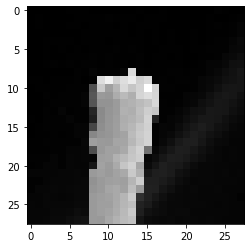

In [39]:
num = 50
y_test_predicted[num]
print('predicted: ', np.argmax(y_test_predicted[num]))
print('truth: ', test_labels[num])

plt.imshow(test_images[num], cmap=plt.cm.binary)
plt.show()

<a id='7'></a>
<div class="alert alert-block alert-danger">
   <h2>
    7 References
    </h2>
</div>

https://www.youtube.com/watch?v=44U8jJxaNp8

https://keras-team.github.io/keras-tuner/